In [ ]:
from fastai.text import *

## Reduce original dataset to questions

In [ ]:
path = Config().data_path()/'giga-fren'

You only need to execute the setup cells once, uncomment to run. The dataset can be downloaded [here](https://s3.amazonaws.com/fast-ai-nlp/giga-fren.tgz).

In [ ]:
#! wget https://s3.amazonaws.com/fast-ai-nlp/giga-fren.tgz -P {path}
#! tar xf {path}/giga-fren.tgz -C {path} 

# with open(path/'giga-fren.release2.fixed.fr') as f:
#    fr = f.read().split('\n')

# with open(path/'giga-fren.release2.fixed.en') as f:
#    en = f.read().split('\n')

# re_eq = re.compile('^(Wh[^?.!]+\?)')
# re_fq = re.compile('^([^?.!]+\?)')
# en_fname = path/'giga-fren.release2.fixed.en'
# fr_fname = path/'giga-fren.release2.fixed.fr'

# lines = ((re_eq.search(eq), re_fq.search(fq)) 
#         for eq, fq in zip(open(en_fname, encoding='utf-8'), open(fr_fname, encoding='utf-8')))
# qs = [(e.group(), f.group()) for e,f in lines if e and f]

# qs = [(q1,q2) for q1,q2 in qs]
# df = pd.DataFrame({'fr': [q[1] for q in qs], 'en': [q[0] for q in qs]}, columns = ['en', 'fr'])
# df.to_csv(path/'questions_easy.csv', index=False)

# del en, fr, lines, qs, df # free RAM or restart the nb 

In [ ]:
### fastText pre-trained word vectors https://fasttext.cc/docs/en/crawl-vectors.html
#! wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.fr.300.bin.gz -P {path}
#! wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz -P {path}
#! gzip -d {path}/cc.fr.300.bin.gz 
#! gzip -d {path}/cc.en.300.bin.gz

In [ ]:
path.ls()

[PosixPath('/home/stas/.fastai/data/giga-fren/models'),
 PosixPath('/home/stas/.fastai/data/giga-fren/giga-fren.release2.fixed.en'),
 PosixPath('/home/stas/.fastai/data/giga-fren/giga-fren.release2.fixed.fr'),
 PosixPath('/home/stas/.fastai/data/giga-fren/data_save.pkl'),
 PosixPath('/home/stas/.fastai/data/giga-fren/cc.en.300.bin'),
 PosixPath('/home/stas/.fastai/data/giga-fren/questions_easy.csv'),
 PosixPath('/home/stas/.fastai/data/giga-fren/cc.fr.300.bin')]

## Put them in a DataBunch

Our questions look like this now:

In [ ]:
df = pd.read_csv(path/'questions_easy.csv')
df.head()

,en,fr
0,What is light ?,Qu’est-ce que la lumière?
1,Who are we?,Où sommes-nous?
2,Where did we come from?,D'où venons-nous?
3,What would we do without it?,Que ferions-nous sans elle ?
4,What is the absolute location (latitude and lo...,Quelle sont les coordonnées (latitude et longi...


To make it simple, we lowercase everything.

In [ ]:
df['en'] = df['en'].apply(lambda x:x.lower())
df['fr'] = df['fr'].apply(lambda x:x.lower())

The first thing is that we will need to collate inputs and targets in a batch: they have different lengths so we need to add padding to make the sequence length the same;

In [ ]:
def seq2seq_collate(samples:BatchSamples, pad_idx:int=1, pad_first:bool=True, backwards:bool=False) -> Tuple[LongTensor, LongTensor]:
    "Function that collect samples and adds padding. Flips token order if needed"
    samples = to_data(samples)
    max_len_x,max_len_y = max([len(s[0]) for s in samples]),max([len(s[1]) for s in samples])
    res_x = torch.zeros(len(samples), max_len_x).long() + pad_idx
    res_y = torch.zeros(len(samples), max_len_y).long() + pad_idx
    if backwards: pad_first = not pad_first
    for i,s in enumerate(samples):
        if pad_first: 
            res_x[i,-len(s[0]):],res_y[i,-len(s[1]):] = LongTensor(s[0]),LongTensor(s[1])
        else:         
            res_x[i,:len(s[0]):],res_y[i,:len(s[1]):] = LongTensor(s[0]),LongTensor(s[1])
    if backwards: res_x,res_y = res_x.flip(1),res_y.flip(1)
    return res_x,res_y

Then we create a special `DataBunch` that uses this collate function.

In [ ]:
class Seq2SeqDataBunch(TextDataBunch):
    "Create a `TextDataBunch` suitable for training an RNN classifier."
    @classmethod
    def create(cls, train_ds, valid_ds, test_ds=None, path:PathOrStr='.', bs:int=32, val_bs:int=None, pad_idx=1,
               pad_first=False, device:torch.device=None, no_check:bool=False, backwards:bool=False, **dl_kwargs) -> DataBunch:
        "Function that transform the `datasets` in a `DataBunch` for classification. Passes `**dl_kwargs` on to `DataLoader()`"
        datasets = cls._init_ds(train_ds, valid_ds, test_ds)
        val_bs = ifnone(val_bs, bs)
        collate_fn = partial(seq2seq_collate, pad_idx=pad_idx, pad_first=pad_first, backwards=backwards)
        train_sampler = SortishSampler(datasets[0].x, key=lambda t: len(datasets[0][t][0].data), bs=bs//2)
        train_dl = DataLoader(datasets[0], batch_size=bs, sampler=train_sampler, drop_last=True, **dl_kwargs)
        dataloaders = [train_dl]
        for ds in datasets[1:]:
            lengths = [len(t) for t in ds.x.items]
            sampler = SortSampler(ds.x, key=lengths.__getitem__)
            dataloaders.append(DataLoader(ds, batch_size=val_bs, sampler=sampler, **dl_kwargs))
        return cls(*dataloaders, path=path, device=device, collate_fn=collate_fn, no_check=no_check)

And a subclass of `TextList` that will use this `DataBunch` class in the call `.databunch` and will use `TextList` to label (since our targets are other texts).

In [ ]:
class Seq2SeqTextList(TextList):
    _bunch = Seq2SeqDataBunch
    _label_cls = TextList

Thats all we need to use the data block API!

In [ ]:
src = Seq2SeqTextList.from_df(df, path = path, cols='fr').split_by_rand_pct().label_from_df(cols='en', label_cls=TextList)

In [ ]:
np.percentile([len(o) for o in src.train.x.items] + [len(o) for o in src.valid.x.items], 90)

28.0

In [ ]:
np.percentile([len(o) for o in src.train.y.items] + [len(o) for o in src.valid.y.items], 90)

23.0

We remove the items where one of the target is more than 30 tokens long.

In [ ]:
src = src.filter_by_func(lambda x,y: len(x) > 30 or len(y) > 30)

In [ ]:
len(src.train) + len(src.valid)

48352

In [ ]:
data = src.databunch()

In [ ]:
data.save()

In [ ]:
data = load_data(path)

In [ ]:
data.show_batch()

text,target
"xxbos à quoi cela peut - il bien servir , alors que l’on xxunk toujours combien il y aura de ces unités et dans quels domaines elles seront présentes ?","xxbos what use was this , when it was still not known how many such units there would be and in what fields ?"
xxbos quels autres fabricants de dispositifs médicaux avez - vous évalués et certifiés selon la norme iso xxunk : 2003 et le marquage ce ( le cas échéant ) ?,xxbos what medical xxunk companies has your organization audited and certified to iso xxunk and xxunk mark ( where applicable ) ?
"xxbos quel est le lien entre le fep , les fonds structurels , le fonds de cohésion et le xxunk ( fonds européen agricole pour le développement rural ) ?","xxbos what is the link between the eff , structural funds , cohesion fund and xxunk ?"
xxbos quel a été le rôle d'agriculture et agroalimentaire canada ( aac ) dans le processus de révision de la norme nationale sur l'agriculture biologique qui date de 1999 ?,xxbos what was the role of agriculture and agri - food canada ( aafc ) in the initiative to revise the 1999 national standard for organic agriculture ?
xxbos lesquelles des activités de r - d ci - après votre établissement a - t - il menées au cours des trois derniers exercices se terminant en 2003 ?,xxbos which of the following r&d activities were carried out at your establishment over the last three fiscal years ending in 2003 ?


## Model

### Pretrained embeddings

To install fastText:
```
$ git clone https://github.com/facebookresearch/fastText.git
$ cd fastText
$ pip install .
```

In [ ]:
# Installation: https://github.com/facebookresearch/fastText#building-fasttext-for-python
import fastText as ft

In [ ]:
fr_vecs = ft.load_model(str((path/'cc.fr.300.bin')))
en_vecs = ft.load_model(str((path/'cc.en.300.bin')))

We create an embedding module with the pretrained vectors and random data for the missing parts.

In [ ]:
def create_emb(vecs, itos, em_sz=300, mult=1.):
    emb = nn.Embedding(len(itos), em_sz, padding_idx=1)
    wgts = emb.weight.data
    vec_dic = {w:vecs.get_word_vector(w) for w in vecs.get_words()}
    miss = []
    for i,w in enumerate(itos):
        try: wgts[i] = tensor(vec_dic[w])
        except: miss.append(w)
    return emb

In [ ]:
emb_enc = create_emb(fr_vecs, data.x.vocab.itos)
emb_dec = create_emb(en_vecs, data.y.vocab.itos)

In [ ]:
torch.save(emb_enc, path/'models'/'fr_emb.pth')
torch.save(emb_dec, path/'models'/'en_emb.pth')

Free some RAM

In [ ]:
del fr_vecs
del en_vecs

### QRNN seq2seq

Our model we use QRNNs at its base (you can use GRUs or LSTMs by adapting a little bit). Using QRNNs require you have properly installed cuda (a version that matches your PyTorch install). 

In [ ]:
from fastai.text.models.qrnn import QRNN, QRNNLayer

/home/stas/anaconda3/envs/fastai/lib/python3.7/site-packages/torch/utils/cpp_extension.py:166: UserWarning: 

                               !! WARNING !!

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Your compiler (c++) is not compatible with the compiler Pytorch was
built with for this platform, which is g++ on linux. Please
use g++ to to compile your extension. Alternatively, you may
compile PyTorch from source using c++, and then you can also use
c++ to compile your extension.

See https://github.com/pytorch/pytorch/blob/master/CONTRIBUTING.md for help
with compiling PyTorch from source.
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

                              !! WARNING !!

  platform=sys.platform))
/home/stas/anaconda3/envs/fastai/lib/python3.7/site-packages/torch/utils/cpp_extension.py:166: UserWarning: 

                               !! WARNING !!

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

The model in itself consists in an encoder and a decoder

![Seq2seq model](images/seq2seq.png)

The encoder is a (quasi) recurrent neural net and we feed it our input sentence, producing an output (that we discard for now) and a hidden state. That hidden state is then given to the decoder (an other RNN) which uses it in conjunction with the outputs it predicts to get produce the translation. We loop until the decoder produces a padding token (or at 30 iterations to make sure it's not an infinite loop at the beginning of training). 

In [ ]:
class Seq2SeqQRNN(nn.Module):
    def __init__(self, emb_enc, emb_dec, n_hid, max_len, n_layers=2, p_inp:float=0.15, p_enc:float=0.25, 
                 p_dec:float=0.1, p_out:float=0.35, p_hid:float=0.05, bos_idx:int=0, pad_idx:int=1):
        super().__init__()
        self.n_layers,self.n_hid,self.max_len,self.bos_idx,self.pad_idx = n_layers,n_hid,max_len,bos_idx,pad_idx
        self.emb_enc = emb_enc
        self.emb_enc_drop = nn.Dropout(p_inp)
        self.encoder = QRNN(emb_enc.weight.size(1), n_hid, n_layers=n_layers, dropout=p_enc)
        self.out_enc = nn.Linear(n_hid, emb_enc.weight.size(1), bias=False)
        self.hid_dp  = nn.Dropout(p_hid)
        self.emb_dec = emb_dec
        self.decoder = QRNN(emb_dec.weight.size(1), emb_dec.weight.size(1), n_layers=n_layers, dropout=p_dec)
        self.out_drop = nn.Dropout(p_out)
        self.out = nn.Linear(emb_dec.weight.size(1), emb_dec.weight.size(0))
        self.out.weight.data = self.emb_dec.weight.data
        
    def forward(self, inp):
        bs,sl = inp.size()
        self.encoder.reset()
        self.decoder.reset()
        hid = self.initHidden(bs)
        emb = self.emb_enc_drop(self.emb_enc(inp))
        enc_out, hid = self.encoder(emb, hid)
        hid = self.out_enc(self.hid_dp(hid))

        dec_inp = inp.new_zeros(bs).long() + self.bos_idx
        outs = []
        for i in range(self.max_len):
            emb = self.emb_dec(dec_inp).unsqueeze(1)
            out, hid = self.decoder(emb, hid)
            out = self.out(self.out_drop(out[:,0]))
            outs.append(out)
            dec_inp = out.max(1)[1]
            if (dec_inp==self.pad_idx).all(): break
        return torch.stack(outs, dim=1)
    
    def initHidden(self, bs): return one_param(self).new_zeros(self.n_layers, bs, self.n_hid)

#### Loss function

The loss pads output and target so that they are of the same size before using the usual flattened version of cross entropy. We do the same for accuracy.

In [ ]:
def seq2seq_loss(out, targ, pad_idx=1):
    bs,targ_len = targ.size()
    _,out_len,vs = out.size()
    if targ_len>out_len: out  = F.pad(out,  (0,0,0,targ_len-out_len,0,0), value=pad_idx)
    if out_len>targ_len: targ = F.pad(targ, (0,out_len-targ_len,0,0), value=pad_idx)
    return CrossEntropyFlat()(out, targ)

In [ ]:
def seq2seq_acc(out, targ, pad_idx=1):
    bs,targ_len = targ.size()
    _,out_len,vs = out.size()
    if targ_len>out_len: out  = F.pad(out,  (0,0,0,targ_len-out_len,0,0), value=pad_idx)
    if out_len>targ_len: targ = F.pad(targ, (0,out_len-targ_len,0,0), value=pad_idx)
    out = out.argmax(2)
    return (out==targ).float().mean()

#### Bleu metric (see dedicated notebook)

In translation, the metric usually used is BLEU, see the corresponding notebook for the details.

In [ ]:
class NGram():
    def __init__(self, ngram, max_n=5000): self.ngram,self.max_n = ngram,max_n
    def __eq__(self, other):
        if len(self.ngram) != len(other.ngram): return False
        return np.all(np.array(self.ngram) == np.array(other.ngram))
    def __hash__(self): return int(sum([o * self.max_n**i for i,o in enumerate(self.ngram)]))

In [ ]:
def get_grams(x, n, max_n=5000):
    return x if n==1 else [NGram(x[i:i+n], max_n=max_n) for i in range(len(x)-n+1)]

In [ ]:
def get_correct_ngrams(pred, targ, n, max_n=5000):
    pred_grams,targ_grams = get_grams(pred, n, max_n=max_n),get_grams(targ, n, max_n=max_n)
    pred_cnt,targ_cnt = Counter(pred_grams),Counter(targ_grams)
    return sum([min(c, targ_cnt[g]) for g,c in pred_cnt.items()]),len(pred_grams)

In [ ]:
class CorpusBLEU(Callback):
    def __init__(self, vocab_sz):
        self.vocab_sz = vocab_sz
        self.name = 'bleu'
    
    def on_epoch_begin(self, **kwargs):
        self.pred_len,self.targ_len,self.corrects,self.counts = 0,0,[0]*4,[0]*4
    
    def on_batch_end(self, last_output, last_target, **kwargs):
        last_output = last_output.argmax(dim=-1)
        for pred,targ in zip(last_output.cpu().numpy(),last_target.cpu().numpy()):
            self.pred_len += len(pred)
            self.targ_len += len(targ)
            for i in range(4):
                c,t = get_correct_ngrams(pred, targ, i+1, max_n=self.vocab_sz)
                self.corrects[i] += c
                self.counts[i]   += t
    
    def on_epoch_end(self, last_metrics, **kwargs):
        precs = [c/t for c,t in zip(self.corrects,self.counts)]
        len_penalty = exp(1 - self.targ_len/self.pred_len) if self.pred_len < self.targ_len else 1
        bleu = len_penalty * ((precs[0]*precs[1]*precs[2]*precs[3]) ** 0.25)
        return add_metrics(last_metrics, bleu)

We load our pretrained embeddings to create the model.

In [ ]:
emb_enc = torch.load(path/'models'/'fr_emb.pth')
emb_dec = torch.load(path/'models'/'en_emb.pth')

In [ ]:
model = Seq2SeqQRNN(emb_enc, emb_dec, 256, 30, n_layers=2)
learn = Learner(data, model, loss_func=seq2seq_loss, metrics=[seq2seq_acc, CorpusBLEU(len(data.y.vocab.itos))])

In [ ]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


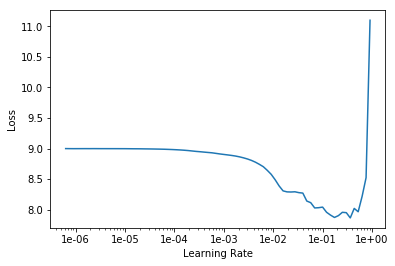

In [ ]:
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(8, 1e-2)

epoch,train_loss,valid_loss,seq2seq_acc,bleu,time
0,6.272254,6.547584,0.175653,0.084508,00:35
1,5.475595,5.798847,0.237578,0.177244,00:34
2,4.998140,4.741757,0.342352,0.250401,00:36
3,4.769568,4.965292,0.316322,0.226495,00:38
4,4.218278,4.942849,0.316456,0.239042,00:37
5,3.686281,4.311011,0.379345,0.282809,00:39
6,3.294988,4.044959,0.409902,0.317913,00:41
7,2.959656,3.956887,0.420079,0.321248,00:42


So how good is our model? Let's see a few predictions.

In [ ]:
def get_predictions(learn, ds_type=DatasetType.Valid):
    learn.model.eval()
    inputs, targets, outputs = [],[],[]
    with torch.no_grad():
        for xb,yb in progress_bar(learn.dl(ds_type)):
            out = learn.model(xb)
            for x,y,z in zip(xb,yb,out):
                inputs.append(learn.data.train_ds.x.reconstruct(x))
                targets.append(learn.data.train_ds.y.reconstruct(y))
                outputs.append(learn.data.train_ds.y.reconstruct(z.argmax(1)))
    return inputs, targets, outputs

In [ ]:
inputs, targets, outputs = get_predictions(learn)

In [ ]:
inputs[700], targets[700], outputs[700]

(Text xxbos pour quelle raison demandez - vous aux émetteurs des renseignements qui n'ont pas à être fournis sur les reçus papier remis aux contribuables ?,
 Text xxbos why are your requiring xxunk to provide information that is not required to be on the paper receipts given to clients ?,
 Text xxbos why would you you to to to to to to the the the the the the ? ?)

In [ ]:
inputs[701], targets[701], outputs[701]

(Text xxbos quels facteurs sont responsables des différences de concentrations des contaminants présents dans les poissons dans les cours d’eau et les lacs du nord ?,
 Text xxbos what factors are responsible for the differences in the level of contaminants found fish in northern rivers and lakes ?,
 Text xxbos what are the differences between the in the the the the the the ? ?)

In [ ]:
inputs[2513], targets[2513], outputs[2513]

(Text xxbos quel est l'impact sur la recherche en amont du brevetage accru dans les sciences du vivant ?,
 Text xxbos what is the impact on upstream research of increased patenting in the life sciences ?,
 Text xxbos what is the impact of on on on on on on on on ? ?)

In [ ]:
inputs[4000], targets[4000], outputs[4000]

(Text xxbos quels changements devrait - on apporter aux processus de réglementation fédéraux et provinciaux ?,
 Text xxbos what changes to federal and provincial regulatory processes would be required ?,
 Text xxbos what changes will be be to the the the the the public ?)

It's usually beginning well, but falls into easy word at the end of the question.

### Teacher forcing

One way to help training is to help the decoder by feeding it the real targets instead of its predictions (if it starts with wrong words, it's very unlikely to give us the right translation). We do that all the time at the beginning, then progressively reduce the amount of teacher forcing.

In [ ]:
class TeacherForcing(LearnerCallback):
    
    def __init__(self, learn, end_epoch):
        super().__init__(learn)
        self.end_epoch = end_epoch
    
    def on_batch_begin(self, last_input, last_target, train, **kwargs):
        if train: return {'last_input': [last_input, last_target]}
    
    def on_epoch_begin(self, epoch, **kwargs):
        self.learn.model.pr_force = 1 - 0.5 * epoch/self.end_epoch

In [ ]:
class Seq2SeqQRNN(nn.Module):
    def __init__(self, emb_enc, emb_dec, n_hid, max_len, n_layers=2, p_inp:float=0.15, p_enc:float=0.25, 
                 p_dec:float=0.1, p_out:float=0.35, p_hid:float=0.05, bos_idx:int=0, pad_idx:int=1):
        super().__init__()
        self.n_layers,self.n_hid,self.max_len,self.bos_idx,self.pad_idx = n_layers,n_hid,max_len,bos_idx,pad_idx
        self.emb_enc = emb_enc
        self.emb_enc_drop = nn.Dropout(p_inp)
        self.encoder = QRNN(emb_enc.weight.size(1), n_hid, n_layers=n_layers, dropout=p_enc)
        self.out_enc = nn.Linear(n_hid, emb_enc.weight.size(1), bias=False)
        self.hid_dp  = nn.Dropout(p_hid)
        self.emb_dec = emb_dec
        self.decoder = QRNN(emb_dec.weight.size(1), emb_dec.weight.size(1), n_layers=n_layers, dropout=p_dec)
        self.out_drop = nn.Dropout(p_out)
        self.out = nn.Linear(emb_dec.weight.size(1), emb_dec.weight.size(0))
        self.out.weight.data = self.emb_dec.weight.data
        self.pr_force = 0.
        
    def forward(self, inp, targ=None):
        bs,sl = inp.size()
        hid = self.initHidden(bs)
        emb = self.emb_enc_drop(self.emb_enc(inp))
        enc_out, hid = self.encoder(emb, hid)
        hid = self.out_enc(self.hid_dp(hid))

        dec_inp = inp.new_zeros(bs).long() + self.bos_idx
        res = []
        for i in range(self.max_len):
            emb = self.emb_dec(dec_inp).unsqueeze(1)
            outp, hid = self.decoder(emb, hid)
            outp = self.out(self.out_drop(outp[:,0]))
            res.append(outp)
            dec_inp = outp.data.max(1)[1]
            if (dec_inp==self.pad_idx).all(): break
            if (targ is not None) and (random.random()<self.pr_force):
                if i>=targ.shape[1]: break
                dec_inp = targ[:,i]
        return torch.stack(res, dim=1)
    
    def initHidden(self, bs): return one_param(self).new_zeros(self.n_layers, bs, self.n_hid)

In [ ]:
emb_enc = torch.load(path/'models'/'fr_emb.pth')
emb_dec = torch.load(path/'models'/'en_emb.pth')

In [ ]:
model = Seq2SeqQRNN(emb_enc, emb_dec, 256, 30, n_layers=2)
learn = Learner(data, model, loss_func=seq2seq_loss, metrics=[seq2seq_acc, CorpusBLEU(len(data.y.vocab.itos))],
                callback_fns=partial(TeacherForcing, end_epoch=8))

In [ ]:
learn.fit_one_cycle(8, 1e-2)

epoch,train_loss,valid_loss,seq2seq_acc,bleu,time
0,2.335030,4.213064,0.543526,0.311808,00:50
1,2.240968,4.949047,0.414702,0.356721,00:46
2,2.030350,5.073238,0.391867,0.354593,00:46
3,2.117243,4.553541,0.430130,0.382721,00:45
4,1.999398,3.816537,0.479980,0.395980,00:46
5,2.051997,4.174997,0.430543,0.373515,00:44
6,1.926257,4.096586,0.433852,0.376887,00:44
7,1.931791,4.038434,0.435708,0.376441,00:44


In [ ]:
inputs, targets, outputs = get_predictions(learn)

In [ ]:
inputs[700],targets[700],outputs[700]

(Text xxbos pour quelle raison demandez - vous aux émetteurs des renseignements qui n'ont pas à être fournis sur les reçus papier remis aux contribuables ?,
 Text xxbos why are your requiring xxunk to provide information that is not required to be on the paper receipts given to clients ?,
 Text xxbos why should you not use the cra to the cra ?)

In [ ]:
inputs[2513], targets[2513], outputs[2513]

(Text xxbos quel est l'impact sur la recherche en amont du brevetage accru dans les sciences du vivant ?,
 Text xxbos what is the impact on upstream research of increased patenting in the life sciences ?,
 Text xxbos what is the impact of the on the xxunk of the xxunk of the xxunk ?)

In [ ]:
inputs[4000], targets[4000], outputs[4000]

(Text xxbos quels changements devrait - on apporter aux processus de réglementation fédéraux et provinciaux ?,
 Text xxbos what changes to federal and provincial regulatory processes would be required ?,
 Text xxbos what changes should be made to the regulatory process and the regulatory framework ?)

In [ ]:
#get_bleu(learn)

## Bidir

A second things that might help is to use a bidirectional model for the encoder.

In [ ]:
class Seq2SeqQRNN(nn.Module):
    def __init__(self, emb_enc, emb_dec, n_hid, max_len, n_layers=2, p_inp:float=0.15, p_enc:float=0.25, 
                 p_dec:float=0.1, p_out:float=0.35, p_hid:float=0.05, bos_idx:int=0, pad_idx:int=1):
        super().__init__()
        self.n_layers,self.n_hid,self.max_len,self.bos_idx,self.pad_idx = n_layers,n_hid,max_len,bos_idx,pad_idx
        self.emb_enc = emb_enc
        self.emb_enc_drop = nn.Dropout(p_inp)
        self.encoder = QRNN(emb_enc.weight.size(1), n_hid, n_layers=n_layers, dropout=p_enc, bidirectional=True)
        self.out_enc = nn.Linear(2*n_hid, emb_enc.weight.size(1), bias=False)
        self.hid_dp  = nn.Dropout(p_hid)
        self.emb_dec = emb_dec
        self.decoder = QRNN(emb_dec.weight.size(1), emb_dec.weight.size(1), n_layers=n_layers, dropout=p_dec)
        self.out_drop = nn.Dropout(p_out)
        self.out = nn.Linear(emb_dec.weight.size(1), emb_dec.weight.size(0))
        self.out.weight.data = self.emb_dec.weight.data
        self.pr_force = 0.
        
    def forward(self, inp, targ=None):
        bs,sl = inp.size()
        hid = self.initHidden(bs)
        emb = self.emb_enc_drop(self.emb_enc(inp))
        enc_out, hid = self.encoder(emb, hid)
        
        hid = hid.view(2,self.n_layers, bs, self.n_hid).permute(1,2,0,3).contiguous()
        hid = self.out_enc(self.hid_dp(hid).view(self.n_layers, bs, 2*self.n_hid))

        dec_inp = inp.new_zeros(bs).long() + self.bos_idx
        res = []
        for i in range(self.max_len):
            emb = self.emb_dec(dec_inp).unsqueeze(1)
            outp, hid = self.decoder(emb, hid)
            outp = self.out(self.out_drop(outp[:,0]))
            res.append(outp)
            dec_inp = outp.data.max(1)[1]
            if (dec_inp==self.pad_idx).all(): break
            if (targ is not None) and (random.random()<self.pr_force):
                if i>=targ.shape[1]: break
                dec_inp = targ[:,i]
        return torch.stack(res, dim=1)
    
    def initHidden(self, bs): return one_param(self).new_zeros(2*self.n_layers, bs, self.n_hid)

In [ ]:
emb_enc = torch.load(path/'models'/'fr_emb.pth')
emb_dec = torch.load(path/'models'/'en_emb.pth')

In [ ]:
model = Seq2SeqQRNN(emb_enc, emb_dec, 256, 30, n_layers=2)
learn = Learner(data, model, loss_func=seq2seq_loss, metrics=[seq2seq_acc, CorpusBLEU(len(data.y.vocab.itos))],
                callback_fns=partial(TeacherForcing, end_epoch=8))

In [ ]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


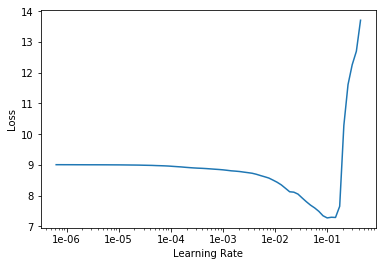

In [ ]:
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(8, 1e-2)

epoch,train_loss,valid_loss,seq2seq_acc,bleu,time
0,2.244290,6.343948,0.388536,0.354548,00:47
1,2.042745,3.911313,0.525344,0.378933,00:50
2,1.876625,5.006873,0.409836,0.372162,00:48
3,1.989081,3.710540,0.503919,0.409202,00:48
4,1.804112,4.398979,0.427331,0.381098,00:47
5,1.949583,4.069941,0.449399,0.394692,00:46
6,1.774466,3.915257,0.452546,0.394610,00:47
7,1.925855,3.910456,0.449511,0.390513,00:46


In [ ]:
inputs, targets, outputs = get_predictions(learn)

In [ ]:
inputs[700], targets[700], outputs[700]

(Text xxbos pour quelle raison demandez - vous aux émetteurs des renseignements qui n'ont pas à être fournis sur les reçus papier remis aux contribuables ?,
 Text xxbos why are your requiring xxunk to provide information that is not required to be on the paper receipts given to clients ?,
 Text xxbos why do you need to support the information to the the application of the claim ?)

In [ ]:
inputs[701], targets[701], outputs[701]

(Text xxbos quels facteurs sont responsables des différences de concentrations des contaminants présents dans les poissons dans les cours d’eau et les lacs du nord ?,
 Text xxbos what factors are responsible for the differences in the level of contaminants found fish in northern rivers and lakes ?,
 Text xxbos what factors are the in the in the north and in the north - based production ?)

In [ ]:
inputs[4001], targets[4001], outputs[4001]

(Text xxbos en quoi consiste la politique des retombées industrielles et régionales ( rir ) ?,
 Text xxbos what is the industrial and regional benefits ( irb ) policy ?,
 Text xxbos what is the policy policy ( policy ) ?)

In [ ]:
#get_bleu(learn)

## Attention

Attention is a technique that uses the output of our encoder: instead of discarding it entirely, we use it with our hidden state to pay attention to specific words in the input sentence for the predictions in the output sentence. Specifically, we compute attention weights, then add to the input of the decoder the linear combination of the output of the encoder, with those attention weights.

In [ ]:
def init_param(*sz): return nn.Parameter(torch.randn(sz)/math.sqrt(sz[0]))

In [ ]:
class Seq2SeqQRNN(nn.Module):
    def __init__(self, emb_enc, emb_dec, n_hid, max_len, n_layers=2, p_inp:float=0.15, p_enc:float=0.25, 
                 p_dec:float=0.1, p_out:float=0.35, p_hid:float=0.05, bos_idx:int=0, pad_idx:int=1):
        super().__init__()
        self.n_layers,self.n_hid,self.max_len,self.bos_idx,self.pad_idx = n_layers,n_hid,max_len,bos_idx,pad_idx
        self.emb_enc = emb_enc
        self.emb_enc_drop = nn.Dropout(p_inp)
        self.encoder = QRNN(emb_enc.weight.size(1), n_hid, n_layers=n_layers, dropout=p_enc, bidirectional=True)
        self.out_enc = nn.Linear(2*n_hid, emb_enc.weight.size(1), bias=False)
        self.hid_dp  = nn.Dropout(p_hid)
        self.emb_dec = emb_dec
        emb_sz = emb_dec.weight.size(1)
        self.decoder = QRNN(emb_sz + 2*n_hid, emb_dec.weight.size(1), n_layers=n_layers, dropout=p_dec)
        self.out_drop = nn.Dropout(p_out)
        self.out = nn.Linear(emb_sz, emb_dec.weight.size(0))
        self.out.weight.data = self.emb_dec.weight.data #Try tying
        self.enc_att = nn.Linear(2*n_hid, emb_sz, bias=False)
        self.hid_att = nn.Linear(emb_sz, emb_sz)
        self.V =  init_param(emb_sz)
        self.pr_force = 0.
        
    def forward(self, inp, targ=None):
        bs,sl = inp.size()
        hid = self.initHidden(bs)
        emb = self.emb_enc_drop(self.emb_enc(inp))
        enc_out, hid = self.encoder(emb, hid)
        
        hid = hid.view(2,self.n_layers, bs, self.n_hid).permute(1,2,0,3).contiguous()
        hid = self.out_enc(self.hid_dp(hid).view(self.n_layers, bs, 2*self.n_hid))

        dec_inp = inp.new_zeros(bs).long() + self.bos_idx
        res = []
        enc_att = self.enc_att(enc_out)
        for i in range(self.max_len):
            hid_att = self.hid_att(hid[-1])
            u = torch.tanh(enc_att + hid_att[:,None])
            attn_wgts = F.softmax(u @ self.V, 1)
            ctx = (attn_wgts[...,None] * enc_out).sum(1)
            emb = self.emb_dec(dec_inp)
            outp, hid = self.decoder(torch.cat([emb, ctx], 1)[:,None], hid)
            outp = self.out(self.out_drop(outp[:,0]))
            res.append(outp)
            dec_inp = outp.data.max(1)[1]
            if (dec_inp==self.pad_idx).all(): break
            if (targ is not None) and (random.random()<self.pr_force):
                if i>=targ.shape[1]: break
                dec_inp = targ[:,i]
        return torch.stack(res, dim=1)
    
    def initHidden(self, bs): return one_param(self).new_zeros(2*self.n_layers, bs, self.n_hid)

In [ ]:
emb_enc = torch.load(path/'models'/'fr_emb.pth')
emb_dec = torch.load(path/'models'/'en_emb.pth')

In [ ]:
model = Seq2SeqQRNN(emb_enc, emb_dec, 256, 30, n_layers=2)
learn = Learner(data, model, loss_func=seq2seq_loss, metrics=[seq2seq_acc, CorpusBLEU(len(data.y.vocab.itos))],
                callback_fns=partial(TeacherForcing, end_epoch=8))

In [ ]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


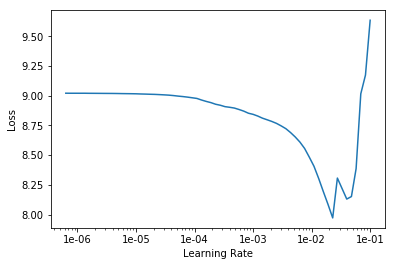

In [ ]:
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(8, 3e-3)

epoch,train_loss,valid_loss,seq2seq_acc,bleu,time
0,2.452436,4.709918,0.412980,0.208454,01:03
1,2.137345,4.476718,0.422126,0.344813,00:57
2,1.974048,3.824592,0.472997,0.377652,00:58
3,1.813645,3.864258,0.470798,0.389968,00:57
4,1.818273,4.042902,0.456217,0.390355,00:56
5,1.668895,3.635575,0.482699,0.411627,00:56
6,1.620335,3.741779,0.474715,0.410962,00:56
7,1.852314,3.721396,0.471986,0.402945,00:55


In [ ]:
inputs, targets, outputs = get_predictions(learn)

In [ ]:
inputs[700], targets[700], outputs[700]

(Text xxbos pour quelle raison demandez - vous aux émetteurs des renseignements qui n'ont pas à être fournis sur les reçus papier remis aux contribuables ?,
 Text xxbos why are your requiring xxunk to provide information that is not required to be on the paper receipts given to clients ?,
 Text xxbos why do you think to the information that the information that not be provided on the payment ?)

In [ ]:
inputs[701], targets[701], outputs[701]

(Text xxbos quels facteurs sont responsables des différences de concentrations des contaminants présents dans les poissons dans les cours d’eau et les lacs du nord ?,
 Text xxbos what factors are responsible for the differences in the level of contaminants found fish in northern rivers and lakes ?,
 Text xxbos what factors are the of the levels of contaminants in in in water in water and water in the north ?)

In [ ]:
inputs[4002], targets[4002], outputs[4002]

(Text xxbos quels sont les avantages et les inconvénients à ce jour de cette approche ?,
 Text xxbos what are the advantages and disadvantages of this approach to date ?,
 Text xxbos what are the advantages and disadvantages of this approach ?)